In [1]:
import numpy as np
from scipy.linalg import fractional_matrix_power, svd, svdvals, eig, eigvals
import matplotlib.pyplot as plt

In [2]:
k = 3
n = 10
d = 30

In [3]:
def check_orth(A):
    return np.allclose(A.T.dot(A), np.eye(A.shape[1]))

def stiefel_sample(rows, cols):
    # uniformly sample from St(rows, cols) according to
    # https://math.stackexchange.com/questions/3097862/uniform-distribution-on-stiefel-manifold
    X = np.random.randn(rows, cols)
    return X.dot(fractional_matrix_power(X.T.dot(X), -0.5))

def stiefel_samples(rows, cols, n_samples):
    samples = []
    for i in range(n_samples):
        samples.append(stiefel_sample(rows, cols))
    return samples

In [4]:
alpha = stiefel_sample(d, n) # V_n(R^d)
x = stiefel_sample(n, k) # V_k(R^n)
y = alpha.dot(x) # alpha * x should be in V_k(R^d)

print(alpha.shape, check_orth(alpha))
print(x.shape, check_orth(x))
print(y.shape, check_orth(y))

(30, 10) True
(10, 3) True
(30, 3) True


In [5]:
def orth_proj(X):
    u, _, vh = np.linalg.svd(X)
    k = min(X.shape)
    return u[:,:k].dot(vh)

# def orth_proj2(X):
#     u, _, _ = np.linalg.svd(X)
#     k = min(X.shape)
#     return u[:,:k]

def dist1(X, Y):
    return np.linalg.norm(X - Y, 'fro')

def dist2(X, Y):
    return np.linalg.norm(X.dot(X.T) - Y.dot(Y.T), 'fro')

In [6]:
X = np.random.randn(n, k)
Xhat = orth_proj(X)
# Xhat2 = orth_proj2(X)

print(X.shape, check_orth(X)) # NOT on Stiefel
print(Xhat.shape, check_orth(Xhat)) 
# print(Xhat2.shape, check_orth(Xhat2)) 
print( )

print('d1(X, Xhat)', dist1(X, Xhat))
# print('d1(X, Xhat2)', dist1(X, Xhat2))
# print('d1(Xhat, Xhat2)', dist1(Xhat, Xhat2))

print("d2(X, Xhat)", dist2(X, Xhat))
# print("d2(X, Xhat2)", dist2(X, Xhat2))
# print("d2(Xhat, Xhat2)", dist2(Xhat, Xhat2))

(10, 3) False
(10, 3) True

d1(X, Xhat) 3.5101775072366155
d2(X, Xhat) 18.07811487647534


In [7]:
# num_trials = 100
# dists_all= np.zeros((num_trials, 4))

# alpha = stiefel_sample(d, n)

# for i in range(num_trials):
#     y = stiefel_sample(d, k)
#     A = alpha.T.dot(y)
#     dists_all[i, 0] = dist1(A, orth_proj(A))**2
#     dists_all[i, 1] = dist1(A, orth_proj2(A))**2
#     dists_all[i, 2] = dist2(A, orth_proj(A))**2
#     dists_all[i, 3] = dist2(A, orth_proj2(A))**2
# dists_all.mean(axis=0), dists_all.std(axis=0)

In [8]:
import autograd.numpy as anp
from pymanopt.manifolds.stiefel import Stiefel
from pymanopt.core.problem import Problem
from pymanopt.function import autograd,numpy
from pymanopt import optimizers

In [9]:
alpha = stiefel_sample(d, n) # V_n(R^d)
xs = stiefel_samples(n, k, 5)
ys = [alpha.dot(x) for x in xs]
yhats = [orth_proj(alpha.T.dot(y)) for y in ys]

In [10]:
st_dn = Stiefel(d, n) 

@autograd(st_dn)
#@numpy(st_dn)
def cost(point):
    return -anp.sum([anp.linalg.norm(anp.dot(point.T, y), 'nuc') for y in ys])
    #return -anp.sum([anp.trace(y.T.dot(point).dot(point.T).dot(y)) for y in ys])
    #return -anp.trace((point.T @ y) @ (point.T @ y).T)
    #return anp.linalg.norm(y - point @ , 'fro')**2

# @numpy(st_dn)
# def euclidean_gradient(point):
#     return -2*y.dot(y.T).dot(point)

init_point = st_dn.random_point()
#init_point = alpha

problem = Problem(st_dn, cost=cost)#, euclidean_gradient=euclidean_gradient)
#optimizer = optimizers.ConjugateGradient()
optimizer = optimizers.SteepestDescent(verbosity=1)
result = optimizer.run(problem, initial_point=init_point)

rp = st_dn.random_point()

print('cost', cost(alpha), cost(rp), cost(result.point))
print("d1", dist1(rp, alpha), dist1(result.point, alpha))
print("d2", dist2(rp, alpha), dist2(result.point, alpha))
print("d1", np.mean([dist1(rp.dot(x), y) for x, y in zip(xs, ys)]),
            np.mean([dist1(result.point.dot(x), y) for x, y in zip(xs, ys)]))
print("d2", np.mean([dist2(rp.dot(x), y) for x, y in zip(xs, ys)]),
            np.mean([dist2(result.point.dot(x), y) for x, y in zip(xs, ys)]))

Optimizing...
Terminated - min grad norm reached after 184 iterations, 0.50 seconds.

cost -14.99999999999997 -8.04268511645315 -14.999999999999572
d1 4.21561325300715 4.153974587080088
d2 3.685044172516831 2.998878227140595e-06
d1 2.2826850971359827 2.1583933754128117
d2 2.303219996616884 2.019214845066143


/Users/harlinl/opt/anaconda3/envs/PIC16B/lib/python3.8/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")
/Users/harlinl/opt/anaconda3/envs/PIC16B/lib/python3.8/site-packages/pymanopt/optimizers/line_search.py:44: RuntimeWarning: divide by zero encountered in double_scalars
  alpha = self.initial_step_size / norm_d
/Users/harlinl/opt/anaconda3/envs/PIC16B/lib/python3.8/site-packages/pymanopt/optimizers/line_search.py:48: RuntimeWarning: invalid value encountered in multiply
  newx = manifold.retraction(x, alpha * d)
/Users/harlinl/opt/anaconda3/envs/PIC16B/lib/python3.8/site-packages/pymanopt/optimizers/line_search.py:54: RuntimeWarning: invalid value encountered in double_scalars
  newf > f0 + self.sufficient_decrease * alpha * df0
/Users/harlinl/opt/anaconda3/envs/PIC16B/lib/python3.8/site-packages/pymanopt/optimizers/line_search.py:72: RuntimeWarning: invalid value encountered in double_scalars
 

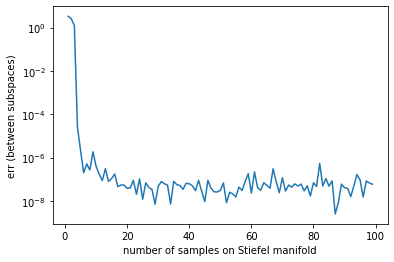

In [11]:
alpha = stiefel_sample(d, n) # V_n(R^d)
st_dn = Stiefel(d, n) 
dists = []
ms = range(100)

for m in ms:
    xs = stiefel_samples(n, k, m)
    ys = [alpha.dot(x) for x in xs]

    @autograd(st_dn)
    def cost(point):
        return -anp.sum([anp.linalg.norm(anp.dot(point.T, y), 'nuc') for y in ys])

    init_point = st_dn.random_point()

    problem = Problem(st_dn, cost=cost)
    optimizer = optimizers.SteepestDescent(verbosity=0)
    result = optimizer.run(problem, initial_point=init_point)
    dists.append(dist2(result.point, alpha))

plt.semilogy(ms, dists)
plt.xlabel('number of samples on Stiefel manifold')
plt.ylabel('err (between subspaces)')
plt.show()

In [13]:
yhats = [orth_proj(result.point.T.dot(y)) for y in ys]

In [19]:
np.array(yhats).shape

(99, 10, 3)

In [18]:
from scipy.spatial.distance import pdist
pdist_yhats = pdist(yhats)
pdist_xs = pdist(xs)

ValueError: A 2-dimensional array must be passed.